In [1]:
# Following Applying Statistical Modeling & Machine Learning to Perform Time-Series Forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# Read data
df = pd.read_csv('reviews.csv')

### Data peeking
Data contains a timestamp for every review made in the area in the last ? years.

In [3]:
display(df.head())

display(df.shape)

display(df.dtypes)

display(df.describe()) # absolutely useless for this data format

display(df.isnull().values.any())

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,344,2016-06-14
3,344,2016-12-11
4,344,2016-12-30


(1113802, 2)

listing_id     int64
date          object
dtype: object

,listing_id
count,1.113802e+06
mean,1.624439e+07
std,1.126170e+07
min,1.090000e+02
25%,6.372642e+06
50%,1.549670e+07
75%,2.372888e+07
max,4.530499e+07


False

In [14]:
df = df.rename(columns = {'listing_id': 'ts', 'date': 'ds'})
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds')

# Count reviews per day
df_example = df.groupby('ds').agg({'ts': 'count'})
# Set one row for each day, will be NaN for days without reviews
df_example = df_example.asfreq(freq='1D')
# Sort
df_example = df_example.sort_index(ascending = True)
# Set NaN to 0
df_example.fillna(value = 0, inplace=True)
# Remove 2020, not dealing with COVID-19 now...
df_example = df_example.loc[df_example.index < '2020-01-01']
display(df_example.tail())

,ts
ds,
2019-12-27,993.0
2019-12-28,1036.0
2019-12-29,1279.0
2019-12-30,1194.0
2019-12-31,980.0


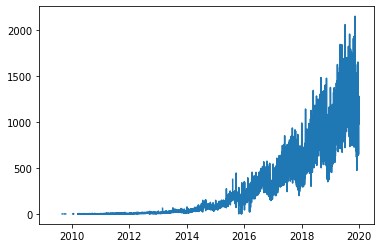

In [5]:
plt.plot(df_example['ts'])

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Dickey Fuller test tests if time series is stationary, p-value returned is for the null hypothesis (series is stationary). As can be clearly seen neither the mean nor the std is stationary.

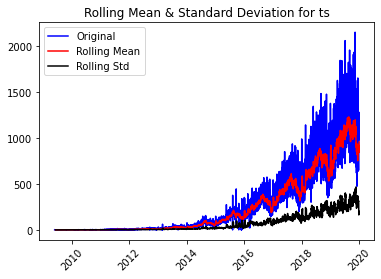

Results of Dickey-Fuller Test:
Test Statistic                    0.359086
p-value                           0.979899
# Lags Used                      30.000000
Number of Observations Used    3841.000000
Critical Value (1%)              -3.432054
Critical Value (5%)              -2.862293
Critical Value (10%)             -2.567171
dtype: float64


In [16]:
test_stationarity(df_example, 'ts') # this p-value is.. high, but okay

In [18]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

c:\users\rnydestedt\miniconda3\envs\cs\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
<ipython-input-19-65b4e24a91ab>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
<ipython-input-19-65b4e24a91ab>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example_transform['ts_log_ewma_diff'] = df_example_tra

,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-07-03,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-04,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-05,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-06,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09-01,2.0,0.693147,0.396084,1.571429,0.693147,0.428571,0.297063,0.167346,0.525801


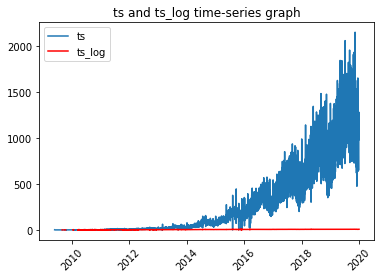

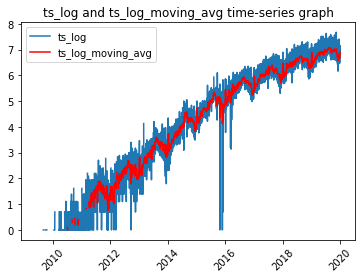

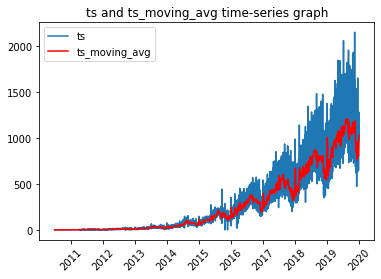

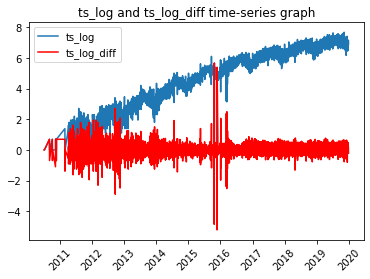

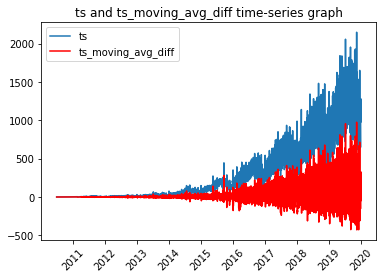

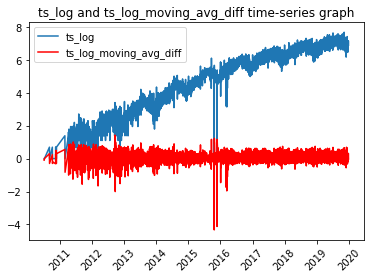

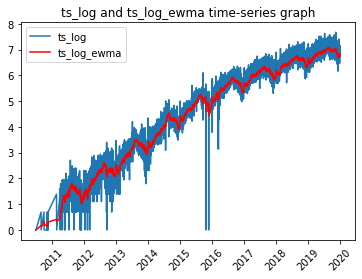

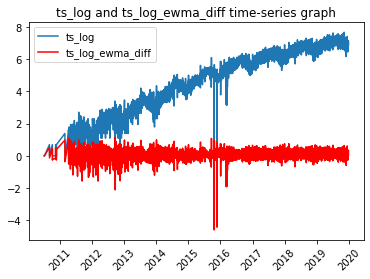

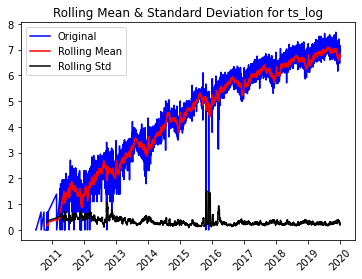

Results of Dickey-Fuller Test:
Test Statistic                   -2.206582
p-value                           0.203865
# Lags Used                      27.000000
Number of Observations Used    3072.000000
Critical Value (1%)              -3.432480
Critical Value (5%)              -2.862481
Critical Value (10%)             -2.567271
dtype: float64


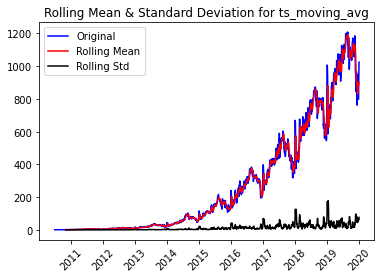

Results of Dickey-Fuller Test:
Test Statistic                    0.187132
p-value                           0.971531
# Lags Used                      29.000000
Number of Observations Used    3070.000000
Critical Value (1%)              -3.432482
Critical Value (5%)              -2.862482
Critical Value (10%)             -2.567271
dtype: float64


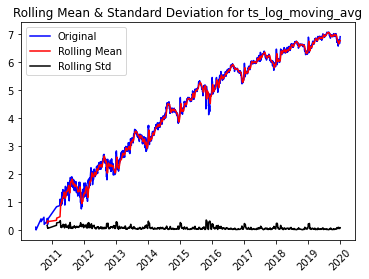

Results of Dickey-Fuller Test:
Test Statistic                   -2.144855
p-value                           0.226865
# Lags Used                      28.000000
Number of Observations Used    3071.000000
Critical Value (1%)              -3.432481
Critical Value (5%)              -2.862482
Critical Value (10%)             -2.567271
dtype: float64


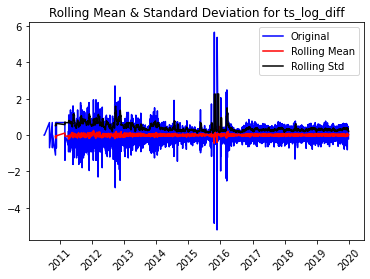

Results of Dickey-Fuller Test:
Test Statistic                -1.244522e+01
p-value                        3.677388e-23
# Lags Used                    2.800000e+01
Number of Observations Used    3.071000e+03
Critical Value (1%)           -3.432481e+00
Critical Value (5%)           -2.862482e+00
Critical Value (10%)          -2.567271e+00
dtype: float64


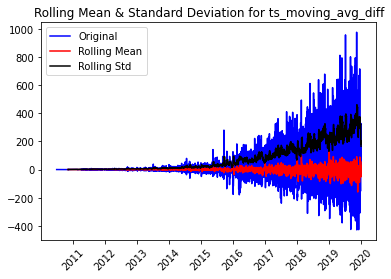

Results of Dickey-Fuller Test:
Test Statistic                -1.178499e+01
p-value                        1.013802e-21
# Lags Used                    2.800000e+01
Number of Observations Used    3.071000e+03
Critical Value (1%)           -3.432481e+00
Critical Value (5%)           -2.862482e+00
Critical Value (10%)          -2.567271e+00
dtype: float64


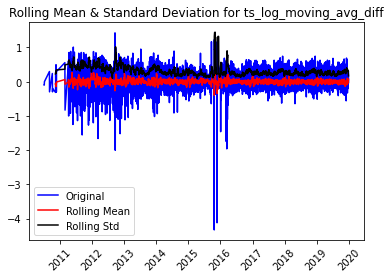

Results of Dickey-Fuller Test:
Test Statistic                -1.320097e+01
p-value                        1.094693e-24
# Lags Used                    2.900000e+01
Number of Observations Used    3.070000e+03
Critical Value (1%)           -3.432482e+00
Critical Value (5%)           -2.862482e+00
Critical Value (10%)          -2.567271e+00
dtype: float64


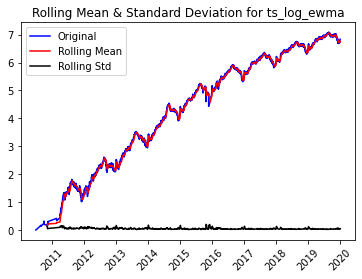

Results of Dickey-Fuller Test:
Test Statistic                   -2.425888
p-value                           0.134563
# Lags Used                      29.000000
Number of Observations Used    3070.000000
Critical Value (1%)              -3.432482
Critical Value (5%)              -2.862482
Critical Value (10%)             -2.567271
dtype: float64


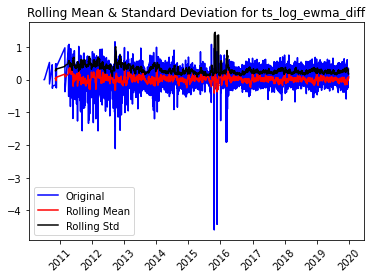

Results of Dickey-Fuller Test:
Test Statistic                -1.075953e+01
p-value                        2.541815e-19
# Lags Used                    2.900000e+01
Number of Observations Used    3.070000e+03
Critical Value (1%)           -3.432482e+00
Critical Value (5%)           -2.862482e+00
Critical Value (10%)          -2.567271e+00
dtype: float64


In [19]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example_transform.head())

# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

In [20]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

<ipython-input-21-aa4494657de5>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)
c:\users\rnydestedt\miniconda3\envs\cs\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\rnydestedt\miniconda3\envs\cs\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labe

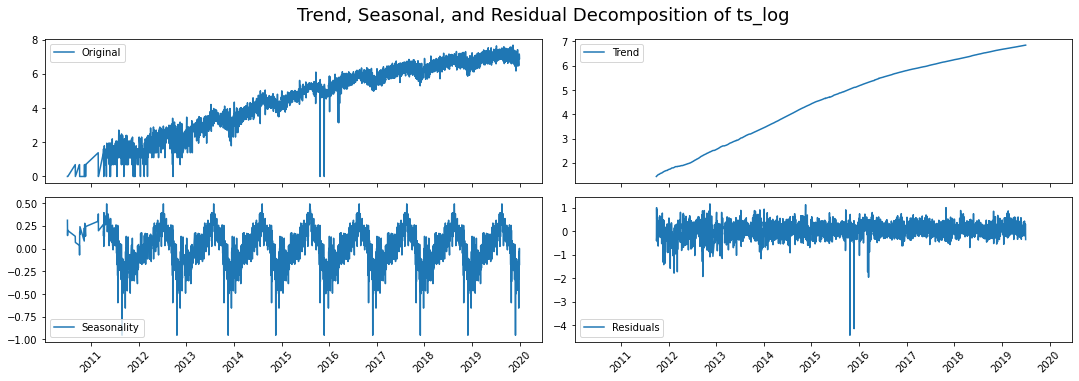

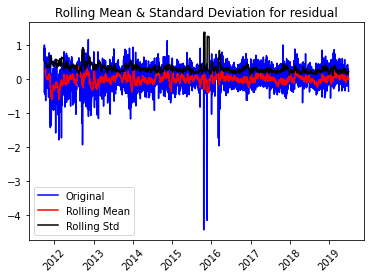

Results of Dickey-Fuller Test:
Test Statistic                -7.535914e+00
p-value                        3.478933e-11
# Lags Used                    2.700000e+01
Number of Observations Used    2.708000e+03
Critical Value (1%)           -3.432767e+00
Critical Value (5%)           -2.862608e+00
Critical Value (10%)          -2.567338e+00
dtype: float64


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')